In [2]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [5]:
s = 2
r = 0.03
rho = 0.05
Var = 0.07
zmean = np.exp(Var/2)
Corr = 0.9
the = -np.log(Corr)
sig2 = 2*the*Var

I = 100
amin = -0.02
amax = 4
a = np.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

J = 40
zmin = zmean*0.8
zmax = zmean*1.2
z = np.linspace(zmin,zmax,J).reshape((J,1))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

aa = a * np.ones((I, J))
zz = np.ones((I, J)) * z.T

mu = (-the * np.log(z) + sig2/2)*z
s2 = sig2*z**2

maxit= 100
crit = 10**(-6)
Delta = 1000

Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

chi =  -np.minimum(mu,0)/dz + s2/(2*dz2)
yy =  np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/dz2
zeta = np.maximum(mu,0)/dz + s2/(2*dz2)

In [6]:
chi.shape

(40, 1)

In [91]:
# This will be the upperdiagonal of the B_switch
updiag = np.zeros((I,1))
for j in range(J):
    updiag = np.vstack((updiag, np.tile(zeta[j], (I,1))))

# This will be the center diagonal of the B_switch
centdiag = np.tile(chi[0]+yy[0],(I,1))
for j in range(1,J-1):
    centdiag = np.vstack((centdiag, np.tile(yy[j], (I,1))))
centdiag = np.vstack((centdiag, np.tile(yy[J-1]+zeta[J-1], (I,1))))

# This will be the lower diagonal of the B_switch
lowdiag = np.tile(chi[1], (I,1))
for j in range(2,J):
    lowdiag = np.vstack((lowdiag, np.tile(chi[j], (I,1))))

# Add up the upper, center, and lower diagonal into a sparse matrix   page 18 matrix C
Bswitch = scipy.sparse.spdiags(centdiag[:,0], 0, I*J, I*J)\
          + scipy.sparse.spdiags(lowdiag[:,0], -I, I*J, I*J)\
          + scipy.sparse.spdiags(updiag[:,0], I, I*J, I*J)

In [120]:
# Initial guess
v0 = (zz + r*aa)**(1-s)/(1-s)/rho
v = copy.deepcopy(v0)

maxit = 30
for n in range(maxit):
    V = copy.deepcopy(v)
    Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amax)**(-s)
    Vaf[I-1,:] = re.reshape((40,))
    Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    re = (z + r*amin)**(-s) 
    Vab[0,:] = re.reshape((40,))
    I_concave = Vab > Vaf
    
    cf = Vaf**(-1/s)
    sf = zz + r*aa - cf
    cb = Vab**(-1/s)
    sb = zz + r*aa - cb
    c0 = zz + r*aa
    Va0 = c0**(-s)
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)
    Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
    c = Va_Upwind**(-1/s)
    u = c**(1-s)/(1-s)

    # CONSTRUCT MATRIX A
    X = -np.minimum(sb,0)/da   
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    Z = Z.reshape(-1,order='F')
    A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
    Y = Y.reshape(-1,order='F')
    A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
    X = X.reshape(-1,order='F')
    X = np.roll(X, -1)
    A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
    AA = A_down + A_diag + A_up
    A = AA + Bswitch
    B = (1/Delta + rho)*scipy.sparse.eye(I*J) - A

    u_stack = u.reshape(-1,order='F')
    V_stack = V.reshape(-1,order='F')
    b = u_stack + V_stack/Delta

    V_stack = scipy.sparse.linalg.spsolve(B, b)
    v = V_stack.reshape((100,40), order='F')

    

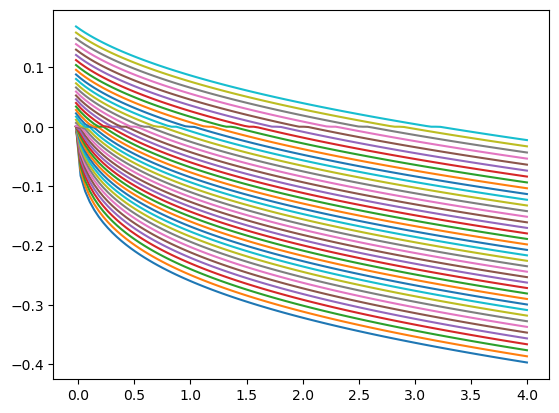

In [125]:
ss = zz + r*aa -c
plt.plot(a,ss)